<a href="https://colab.research.google.com/github/kareemrb27/Lab2.1/blob/master/CV_1_Assignment_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR-10 Image Classification Using CNN Architectures


#### **Objective:**  
Develop and compare deep learning models for **image classification** on the **CIFAR-10 dataset** using different **Convolutional Neural Network (CNN) architectures**. The goal is to train models that can accurately classify images into **10 object categories** and analyze their performance.

#### **Scope:**  
1. **Data Processing & Augmentation:**  
   - Load the **CIFAR-10 dataset** and apply **data augmentation techniques** (random cropping, flipping, and normalization) to improve generalization.  
   - Utilize **DataLoaders** for efficient training and evaluation.

2. **Model Development:**  
   - Implement **three CNN architectures**:  
     - **VGG16**: A deep CNN with multiple convolutional layers.  
     - **VGG19**: An extended version of VGG16 with additional layers.  
     - **ResNet-50**: A deep residual network with skip connections to improve gradient flow.  
   - Develop a **Hybrid Model** that combines **VGG16, VGG19, and ResNet-50** to leverage the strengths of all three architectures.

3. **Training & Optimization:**  
   - Train models using **cross-entropy loss and stochastic gradient descent (SGD)** with momentum.  
   - Implement **learning rate scheduling** (Cosine Annealing) to optimize convergence.  
   - Validate models on the **test dataset** to measure generalization performance.

4. **Evaluation & Performance Analysis:**  
   - Compute **classification metrics**: **Accuracy, Precision, Recall, F1-score**, and **Confusion Matrix**.  
   - Compare the **performance of all four models** and determine which model performs best on the CIFAR-10 dataset.

5. **Visualization & Interpretability:**  
   - Display **model predictions** on test images.  
   - Extract and **visualize convolutional feature maps** to analyze how the models learn image representations.

#### **Expected Outcome:**  
- A **trained and evaluated deep learning model** capable of classifying images from CIFAR-10 with high accuracy.  
- **Comparison of different architectures** to determine the most effective model for image classification.  
- **Insights into model behavior** through feature visualization and performance metrics.  


## Mounting the asset directory containing dataset

In [ ]:
import os

local_assets_b = False

if local_assets_b:
  assets_dir = "/content/assets/Assignment/"

  if not os.path.isdir(assets_dir):
    assert os.path.isfile("assets.zip")
    os.system("unzip assets.zip")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  assets_dir = '/content/drive/MyDrive/IK/CV1/assets/Assignment/' #Use the path of the assets in your drive here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preparation

#### What dataset are we using?
We will be working on CIFAR-10 which is a widely used benchmark dataset in computer vision and machine learning. It consists of 60,000 small-sized color images (32x32 pixels) belonging to 10 different classes, with 6,000 images per class. The dataset is split into a training set of 50,000 images and a test set of 10,000 images. The classes in CIFAR-10 include common objects like airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks. CIFAR-10 serves as a good dataset for evaluating and benchmarking image classification models.

When it comes to transfer learning, VGG is often used as a backbone model. Its pre-trained weights, which have been learned on the large-scale ImageNet dataset, capture generic features like edges, textures, and shapes that are beneficial for various visual recognition tasks. By leveraging the pre-trained VGG model, we can fine-tune it on the CIFAR-10 dataset to perform image classification. The lower-level layers of VGG capture low-level features, such as edges and corners, while the higher-level layers learn more complex features. This enables VGG to extract meaningful representations from images and generalize well to new tasks with limited labeled data.

By fine-tuning VGG on the CIFAR-10 dataset, we can take advantage of the pre-trained weights and learn task-specific features for image classification. This approach is effective when the target task has a similar domain or visual characteristics as the source task on which VGG was pre-trained. Transfer learning with VGG can help achieve better performance on CIFAR-10 by leveraging the knowledge learned from ImageNet, even with a smaller dataset.


These are the classes present in CIFAR-10:

 `('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`

### Image Transformation
We will be performing the following transformations for training:

*   Random Crop
*   Flip
*   Normalize data

Test time Transformations:

* Normalization

In [ ]:
# Import required libraries
import torch  # PyTorch library for tensor computations and deep learning
import torchvision  # PyTorch library for handling image datasets and models
import torchvision.transforms as transforms  # Transformations for image preprocessing

import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimizers for training the model
import torch.nn.functional as F  # Functional API for activation functions and loss functions

import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Visualization

# Define transformations for the training dataset (includes data augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crops a 32x32 region with 4 pixels padding (helps with spatial invariance)
    transforms.RandomHorizontalFlip(),  # Randomly flips the image horizontally (improves generalization)
    transforms.ToTensor(),  # Converts image to PyTorch tensor and normalizes pixel values to [0,1]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2616))
    # Normalizes the image using mean and standard deviation of the CIFAR-10 dataset
])

# Define transformations for the test dataset (only normalization, no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2434, 0.2616))
    # Normalizes test images (same mean and standard deviation as training set)
])


### Dataset

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training. PyTorch provides built-in datasets like MNIST, CIFAR-10, and ImageNet, but custom datasets can also be created to work with specific data.

In [ ]:
## Preparing dataset

# Load the CIFAR-10 training dataset with transformations
trainset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory where the dataset will be stored/downloaded
    train=True,  # Load the training dataset (if False, loads the test set)
    download=True,  # Download the dataset if not already present
    transform=transform_train  # Apply defined transformations (augmentation + normalization)
)

# Load the CIFAR-10 test dataset with transformations
testset = torchvision.datasets.CIFAR10(
    root='./data',  # Directory where the dataset will be stored/downloaded
    train=False,  # Load the test dataset (train=False)
    download=True,  # Download the dataset if not already present
    transform=transform_test  # Apply defined transformations (only normalization)
)


Files already downloaded and verified
Files already downloaded and verified


### Dataloaders

Dataloaders, are utilities that enable efficient data loading and batching. They take a dataset as input and allow users to define batch sizes, shuffle the data, and apply transformations to the samples. Dataloaders are especially useful when dealing with large datasets, as they enable the model to process data in small batches, reducing memory requirements and speeding up training. They are key components in PyTorch that facilitate data handling and preparation for machine learning tasks.

In [ ]:
# Create a DataLoader for the test dataset
testloader = torch.utils.data.DataLoader(
    testset,  # Test dataset
    batch_size=256,  # Number of images per batch (larger batch size speeds up evaluation)
    shuffle=True,  # Shuffle test data for randomized batch order
    num_workers=2  # Number of CPU threads for parallel data loading (improves efficiency)
)

# Create a DataLoader for the training dataset
trainloader = torch.utils.data.DataLoader(
    trainset,  # Training dataset
    batch_size=128,  # Number of images per batch (128 images are processed at a time)
    shuffle=True,  # Shuffle training data at every epoch to improve generalization
    num_workers=2  # Number of CPU threads for parallel data loading
)


In [ ]:
# Define class names corresponding to the CIFAR-10 dataset labels
classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

# Fetch a batch of training images and labels
images, target = next(iter(trainloader))
# `images` is a batch of image tensors with shape (batch_size, channels, height, width)
# `target` contains the corresponding labels for the images

# Convert the PyTorch tensor to a NumPy array for analysis
np_images = images.numpy()

# Print the shapes of the images and target tensors
print(np.shape(np_images))  # Expected shape: (batch_size, 3, 32, 32) → (128, 3, 32, 32)
print(np.shape(target))  # Expected shape: (batch_size,) → (128,)

# Calculate the mean and standard deviation of the first image in the batch
mean = np.mean(np_images[:1], axis=(0, 2, 3))  # Compute mean across channels (RGB)
std = np.std(np_images[:1], axis=(0, 2, 3))  # Compute standard deviation across channels (RGB)

# Print the calculated mean and standard deviation
print("mean: ", mean)  # Displays the per-channel mean values
print("std: ", std)  # Displays the per-channel standard deviation values


(128, 3, 32, 32)
torch.Size([128])
mean:  [0.19538437 0.06863078 0.12578025]
std:  [1.1375759 1.0962102 1.0899098]


## VGG


### What is VGG?
VGG (Visual Geometry Group) is a popular deep convolutional neural network (CNN) architecture developed by the Visual Geometry Group at the University of Oxford. VGGNet is known for its simplicity and effectiveness in image classification tasks. It consists of multiple convolutional layers followed by fully connected layers. The most common variant, VGG-16, has 16 layers, including 13 convolutional layers and 3 fully connected layers. VGGNet has achieved impressive results on various image classification benchmarks, including the ImageNet challenge.

In [ ]:
# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

### VGG16


In [ ]:
import torch
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=10):  # Assuming CIFAR-10 (10 classes)
        super(VGG16, self).__init__()

        # Feature extraction layers (Convolutional + ReLU + MaxPooling)
        self.features = nn.Sequential(
            # Block 1: First two convolutional layers + ReLU activation
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (32x32 -> 16x16)

            # Block 2: Two convolutional layers + ReLU + MaxPooling
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (16x16 -> 8x8)

            # Block 3: Three convolutional layers + ReLU
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            # Block 4: Three convolutional layers + ReLU
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            # Block 5: Three convolutional layers + ReLU + MaxPooling
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # Final downsampling (8x8 -> 4x4)
        )

        # Fully connected layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(True), nn.Dropout(),  # First FC layer
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),  # Second FC layer
            nn.Linear(4096, num_classes)  # Output layer (10 classes for CIFAR-10)
        )

    def forward(self, x):
        """
        Forward pass through the VGG16 model.

        Args:
        - x (Tensor): Input image batch of shape (batch_size, 3, 32, 32) for CIFAR-10

        Returns:
        - Tensor: Output logits of shape (batch_size, num_classes)
        """
        x = self.features(x)  # Pass input through convolutional layers
        x = x.view(x.size(0), -1)  # Flatten feature maps into a 1D vector
        x = self.classifier(x)  # Pass through fully connected layers
        return x


### Train VGG16

In [ ]:
# Instantiate the VGG16 model with 10 output classes (for CIFAR-10)
vgg16_model = VGG16(num_classes=10)

# Select device: Use GPU if available, otherwise default to CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move the model to the selected device (GPU or CPU)
vgg16_model = vgg16_model.to(device)

# Define learning rate
lr = 0.001  # Initial learning rate for training

# Define the loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Stochastic Gradient Descent with momentum and weight decay)
vgg_optimizer = optim.SGD(
    vgg16_model.parameters(),  # Model parameters to optimize
    lr=lr,  # Learning rate (step size for updates)
    momentum=0.9,  # Momentum helps accelerate gradient updates
    weight_decay=5e-4  # L2 regularization (prevents overfitting by penalizing large weights)
)

# Define a learning rate scheduler (Cosine Annealing Learning Rate Decay)
vgg_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    vgg_optimizer,  # Optimizer to adjust learning rate
    T_max=200  # Number of epochs before completing one cosine cycle
)


In [ ]:
def train_batch(epoch, model, optimizer):
    """
    Trains the model for one epoch using the training dataset.

    Args:
    - epoch (int): The current training epoch number.
    - model (nn.Module): The VGG16 model to be trained.
    - optimizer (torch.optim): The optimizer used for updating model weights.

    Prints:
    - Training loss and accuracy for the current epoch.
    """

    print("Epoch", epoch)  # Print the current epoch number
    model.train()  # Set the model to training mode (enables dropout, batch norm updates)

    train_loss = 0  # Variable to accumulate total loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    # Iterate over the training batches
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        # Move input data and targets to the same device as the model (CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass: Get model predictions

        loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate total loss

        _, predicted = outputs.max(1)  # Get predicted class index (argmax over class dimension)
        total += targets.size(0)  # Count total samples processed
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print training statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(trainloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
def validate_batch(epoch, model):
    """
    Evaluates the model on the test dataset for one epoch.

    Args:
    - epoch (int): The current epoch number.
    - model (nn.Module): The trained model to be evaluated.

    Prints:
    - Validation loss and accuracy for the current epoch.
    """

    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)

    test_loss = 0  # Variable to accumulate total validation loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    with torch.no_grad():  # Disable gradient computation (reduces memory usage, speeds up validation)
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # Move inputs and targets to the same device as the model (CPU/GPU)
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)  # Forward pass: Get model predictions
            loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss

            test_loss += loss.item()  # Accumulate total loss
            _, predicted = outputs.max(1)  # Get predicted class (argmax over class dimension)
            total += targets.size(0)  # Count total samples processed
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print validation statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(testloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (test_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
# Set the starting epoch (0 if starting from scratch)
start_epoch = 0

# Train and validate the model for 3 epochs
for epoch in range(start_epoch, start_epoch + 3):

    # Train the model for one epoch using the training dataset
    train_batch(epoch, vgg16_model, vgg_optimizer)

    # Validate the model on the test dataset after each training epoch
    validate_batch(epoch, vgg16_model)

    # Adjust the learning rate based on the Cosine Annealing schedule
    vgg_scheduler.step()


epoch  0


KeyboardInterrupt: 

In [ ]:
# Define the path to save the trained model
model_path = assets_dir + 'vgg16_model.pt'

# Save the model's state dictionary (weights and biases) to the specified path
torch.save(vgg16_model.state_dict(), model_path)


### Evaluate VGG16

In [ ]:
# Define the path where the trained VGG16 model is saved
model_path = assets_dir + 'vgg16_model.pt'
print(model_path)  # Print the model path for verification

# NOTE: Make sure the VGG16 class definition has been run before loading the model
# If starting from this cell, ensure that the model architecture is defined

# Load the saved state dictionary (model weights)
saved_state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# - `map_location=torch.device('cpu')` ensures compatibility if loading on a CPU system

# Load the state dictionary into the VGG16 model
vgg16_model.load_state_dict(saved_state_dict)

# Set the device: Use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
vgg16_model.to(device)

# Set the model to evaluation mode (disables dropout, batch normalization updates)
vgg16_model.eval()


/content/drive/MyDrive/IK/CV1/assets/Assignment/vgg16_model.pt


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
# Validate the model on the test dataset for one epoch (epoch = 1)
validate_batch(1, vgg16_model)

KeyboardInterrupt: 

## VGG19

In [ ]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes=1000):  # Default: 1000 classes (ImageNet)
        super(VGG19, self).__init__()

        # Feature Extraction (Convolutional Layers + ReLU + MaxPooling)
        self.features = nn.Sequential(
            # Block 1 (Conv -> Conv -> MaxPool)
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (224x224 → 112x112)

            # Block 2 (Conv -> Conv -> MaxPool)
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (112x112 → 56x56)

            # Block 3 (Conv -> Conv -> Conv -> Conv -> MaxPool)
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (56x56 → 28x28)

            # Block 4 (Conv -> Conv -> Conv -> Conv -> MaxPool)
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (28x28 → 14x14)

            # Block 5 (Conv -> Conv -> Conv -> Conv -> MaxPool)
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling (14x14 → 7x7)
        )

        # Adaptive Average Pooling Layer (Ensures fixed-size output)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        # Fully Connected Layers (Classifier)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Prevent overfitting
            nn.Linear(512 * 7 * 7, 4096), nn.ReLU(inplace=True), nn.Dropout(0.5),  # First FC layer
            nn.Linear(4096, 4096), nn.ReLU(inplace=True), nn.Dropout(0.5),  # Second FC layer
            nn.Linear(4096, num_classes)  # Output layer
        )

    def forward(self, x):
        """
        Forward pass through the VGG19 model.

        Args:
        - x (Tensor): Input image batch of shape (batch_size, 3, 224, 224)

        Returns:
        - Tensor: Output logits of shape (batch_size, num_classes)
        """
        x = self.features(x)  # Pass input through convolutional layers
        x = self.avgpool(x)  # Apply adaptive average pooling
        x = x.view(x.size(0), -1)  # Flatten feature maps into a 1D vector
        x = self.classifier(x)  # Pass through fully connected layers
        return x


In [ ]:
# Instantiate the VGG19 model with 10 output classes (for CIFAR-10 or similar datasets)
vgg19_model = VGG19(num_classes=10)

# Print the architecture of the VGG19 model
print(vgg19_model)


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [ ]:
# input_tensor = torch.rand(1, 3, 224, 224)
# # Get intermediate layer outputs
# x, layer_outputs = vgg19_model(input_tensor)

# # Print layer outputs
# for i, output in enumerate(layer_outputs):
#     print(f"Output after layer {i + 1}: {output.shape}")

# print("Final layer output: ", x.shape)

In [ ]:
# Calculate the total number of parameters in the VGG19 model
total_params = sum(p.numel() for p in vgg19_model.parameters())

# Print the total number of parameters in the model
print(f"Total Parameters: {total_params}")


Total Parameters: 139622218


### Training VGG19


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np

#### Learning Rate

The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.

In [ ]:
# Fix the learning rate
lr = 0.001

In [ ]:
# Instantiate the device - 'cuda' or 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

In [ ]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

#### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [ ]:
# Define the optimizer
vgg19_optimizer = optim.SGD(vgg19_model.parameters(), lr = lr, momentum=0.9, weight_decay = 5e-4)

#### Scheduler

A scheduler adjusts the learning rate dynamically during training, allowing fine-tuning.

Cosine Annealing: The learning rate starts high and is annealed down to a minimum value following a cosine curve. It helps the model explore the search space broadly at the beginning of training and then refine the search space as it converges.

T_max: This parameter defines the total number of iterations it takes to complete one cycle of the cosine function. The learning rate will follow a cosine curve for the first T_max iterations and then restart the cycle.

Here's a conceptual explanation:

At the start of training, the learning rate is relatively high, allowing the model to explore a larger area of the loss landscape.
As training progresses (over the T_max iterations), the learning rate decreases following a cosine curve.
When T_max iterations are completed, the learning rate is at its minimum.
The scheduler then restarts the cosine curve, and the learning rate starts to increase again, allowing the model to explore broadly for the next cycle.
This approach often helps models converge more efficiently by first exploring broadly and then refining their parameters as training progresses.

In [ ]:
#Define the scheduler
vgg19_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(vgg19_optimizer, T_max = 200)

Set the models in training mode

In [ ]:
# Train the vgg19 model
vgg19_model.train()

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [ ]:
# Move the VGG19 model to the specified device (CPU or GPU)
vgg19_model = vgg19_model.to(device)


In [ ]:
def train_batch(epoch, model, optimizer):
    """
    Trains the model for one epoch using the training dataset.

    Args:
    - epoch (int): The current training epoch number.
    - model (nn.Module): The VGG19 model to be trained.
    - optimizer (torch.optim): The optimizer used for updating model weights.

    Prints:
    - Training loss and accuracy for the current epoch.
    """

    print("Epoch", epoch)  # Print the current epoch number
    model.train()  # Set the model to training mode (enables dropout, batch norm updates)

    train_loss = 0  # Variable to accumulate total loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    # Iterate over the training batches
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        # Move input data and targets to the same device as the model (CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass: Get model predictions

        loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate total loss

        _, predicted = outputs.max(1)  # Get predicted class index (argmax over class dimension)
        total += targets.size(0)  # Count total samples processed
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print training statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(trainloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
def validate_batch(epoch, model):
    """
    Evaluates the model on the test dataset for one epoch.

    Args:
    - epoch (int): The current epoch number.
    - model (nn.Module): The trained model to be evaluated.

    Prints:
    - Validation loss and accuracy for the current epoch.
    """

    global best_acc  # Variable to store the best validation accuracy
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)

    test_loss = 0  # Variable to accumulate total validation loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    with torch.no_grad():  # Disable gradient computation (reduces memory usage, speeds up validation)
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # Move inputs and targets to the same device as the model (CPU/GPU)
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)  # Forward pass: Get model predictions
            loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss

            test_loss += loss.item()  # Accumulate total loss
            _, predicted = outputs.max(1)  # Get predicted class (argmax over class dimension)
            total += targets.size(0)  # Count total samples processed
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print validation statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(testloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (test_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
# Set the starting epoch (0 if starting from scratch)
start_epoch = 0

# Train and validate the VGG19 model for 3 epochs
for epoch in range(start_epoch, start_epoch + 3):

    # Train the model for one epoch using the training dataset
    train_batch(epoch, vgg19_model, vgg19_optimizer)

    # Validate the model on the test dataset after each training epoch
    validate_batch(epoch, vgg19_model)

    # Adjust the learning rate based on the Cosine Annealing schedule
    vgg19_scheduler.step()


#### Save the models

In [ ]:
# Define the path to save the trained VGG19 model
model_path = assets_dir + 'vgg19_model.pt'

# Save the model's state dictionary (weights and biases) to the specified path
torch.save(vgg19_model.state_dict(), model_path)


### Model Evaluation

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the path where the trained VGG19 model is saved
model_path = assets_dir + 'vgg19_model.pt'
print(model_path)  # Print the model path for verification

# NOTE: Make sure the VGG19 class definition has been run before loading the model
# If starting from this cell, ensure that the model architecture is defined

# Load the saved state dictionary (model weights)
saved_state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# - `map_location=torch.device('cpu')` ensures compatibility if loading on a CPU system

# Load the state dictionary into the VGG19 model
vgg19_model.load_state_dict(saved_state_dict)

# Set the device: Use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
vgg19_model = vgg19_model.to(device)

# Set the model to evaluation mode (disables dropout, batch normalization updates)
vgg19_model.eval()


/content/drive/MyDrive/IK/CV1/assets/Assignment/vgg19_model.pt


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

The models performance is the same as the trained models

In [ ]:
# Validate the VGG19 model on the test dataset for one epoch (epoch = 1)
epoch = 1
validate_batch(epoch, vgg19_model)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mean and standard deviation used for normalization (CIFAR-10 dataset)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2434, 0.2616]

# Evaluate the VGG19 model on random test images and display results
for _ in range(10):

    # Fetch a random test image and its label from the test loader
    data, target = next(iter(testloader))

    # Move the image to the appropriate device (CPU/GPU) before inference
    output = vgg19_model(data.to(device))  # Forward pass through the model
    _, predicted = torch.max(output, 1)  # Get the class index with highest probability

    # Select the first image from the batch for visualization
    display_img = data[0]

    # Unnormalize the image (convert back to original pixel values)
    unnormalized_image = display_img.clone()  # Create a copy to avoid modifying the original tensor
    for i in range(3):  # Iterate through the 3 channels (RGB)
        unnormalized_image[i] = (unnormalized_image[i] * std[i]) + mean[i]

    # Convert tensor to NumPy format and reshape for visualization
    plt.imshow(np.transpose(unnormalized_image.numpy(), (1, 2, 0)))

    # Display the predicted and actual labels
    plt.title(f'Predicted: {classes[predicted[0]]}, Actual: {classes[target[0]]}')
    plt.axis('off')  # Remove axis labels for a cleaner visualization
    plt.show()  # Display the image


cpu


TypeError: VGG19.forward() missing 1 required positional argument: 'x'

# Hybrid Model

### What is the Hybrid model?
It is a combination of VGG-16, VGG-19 and ResNet-18 pretrained models fine-tuned on the CIFAR-10 dataset.

In [ ]:
# Import the required libraries
import torch
import torch.nn as nn
import torchvision.models as models

In [ ]:
# Load a pre-trained VGG19 model (trained on ImageNet)
vgg19 = models.vgg19(pretrained=True)

In [ ]:
import torchvision.models as models
from torchvision.models import VGG19_Weights

# Load the pretrained VGG19 model with new API
vgg19_weights = VGG19_Weights.DEFAULT
vgg19 = models.vgg19(weights=vgg19_weights)


In [ ]:
vgg19.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Load a pre-trained ResNet-18 model (trained on ImageNet)
resnet18 = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision.models import VGG19_Weights, VGG16_Weights, ResNet18_Weights
import torch
import torch.nn as nn
import torchvision.models as models

class HybridModel(nn.Module):
    def __init__(self, num_classes=10):  # Default output classes set to 10 (e.g., CIFAR-10)
        super(HybridModel, self).__init__()

        # Load pre-trained VGG19, VGG16, and ResNet18 models
        self.vgg19 = models.vgg19(weights=VGG19_Weights.DEFAULT)
        self.vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # Adaptive average pooling to ensure consistent feature sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer to combine extracted features and classify into num_classes
        self.fc = nn.Linear(512 * 3, num_classes)
        # The final feature representation is a concatenation of outputs from three models
        # 512 from VGG16, 512 from VGG19, and 512 from ResNet18 → total = 512 * 3

    def forward(self, x):
        """
        Forward pass through the hybrid model.

        Args:
        - x (Tensor): Input image batch of shape (batch_size, 3, 224, 224)

        Returns:
        - Tensor: Output logits of shape (batch_size, num_classes)
        """

        # Pass input through VGG16 feature extractor
        x1 = self.vgg16.features(x)  # Output: (batch_size, 512, h, w)
        x1 = self.avgpool(x1)  # Adaptive pooling to (batch_size, 512, 1, 1)
        x1 = torch.flatten(x1, 1)  # Flatten to (batch_size, 512)

        # Pass input through VGG19 feature extractor
        x2 = self.vgg19.features(x)  # Output: (batch_size, 512, h, w)
        x2 = self.avgpool(x2)  # Adaptive pooling to (batch_size, 512, 1, 1)
        x2 = torch.flatten(x2, 1)  # Flatten to (batch_size, 512)

        # Pass input through ResNet18 feature extractor
        x3 = self.resnet18.conv1(x)  # Initial Conv Layer
        x3 = self.resnet18.bn1(x3)  # Batch Normalization
        x3 = self.resnet18.relu(x3)  # ReLU Activation
        x3 = self.resnet18.maxpool(x3)  # MaxPooling

        x3 = self.resnet18.layer1(x3)  # First residual block
        x3 = self.resnet18.layer2(x3)  # Second residual block
        x3 = self.resnet18.layer3(x3)  # Third residual block
        x3 = self.resnet18.layer4(x3)  # Fourth residual block (Output: (batch_size, 512, h, w))

        x3 = self.avgpool(x3)  # Adaptive pooling to (batch_size, 512, 1, 1)
        x3 = torch.flatten(x3, 1)  # Flatten to (batch_size, 512)

        # Concatenate extracted features from all three models
        x = torch.cat((x1, x2, x3), dim=1)  # Shape: (batch_size, 512 * 3)

        # Fully connected layer for classification
        x = self.fc(x)  # Output: (batch_size, num_classes)

        return x  # Returns final class predictions


### Key Features of HybridModel
- Combines Three Powerful Models (VGG16, VGG19, ResNet18) → Leverages their strengths for richer feature extraction.
- Uses Pre-trained Weights → Faster convergence, better performance on small datasets.
- Adaptive Pooling Ensures Consistency → All extracted feature maps are resized to (1,1), ensuring equal feature dimensions.
- Feature Concatenation (512*3 = 1536 Features) → Merges extracted features before classification.
- Fully Connected Layer (fc) for Final Classification → Maps the combined features to num_classes.

This architecture is ideal for image classification tasks requiring diverse feature extraction!

In [ ]:
# Instantiate the HybridModel with 10 output classes (e.g., for CIFAR-10)
hybrid_model = HybridModel(num_classes=10)

# Print the architecture of the HybridModel
print(hybrid_model)


HybridModel(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
# input_tensor = torch.rand(1, 3, 224, 224)
# # Get intermediate layer outputs
# x, layer_outputs = hybrid_model(input_tensor)

# # Print layer outputs
# for i, output in enumerate(layer_outputs):
#     print(f"Output after layer {i + 1}: {output.shape}")

# print("Final layer output: ", x.shape)

In [ ]:
# Calculate the total number of parameters in the HybridModel
total_params = sum(p.numel() for p in hybrid_model.parameters())

# Print the total number of parameters in the model
print(f"Total Parameters: {total_params}")


Total Parameters: 293729666


## Visualize your model architecture

In [ ]:
!pip install --upgrade torch torchvision
!pip install torchviz
!pip install hiddenlayer
!pip install onnx
!pip install onnxruntime
!pip install onnx pydot graphviz


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

### Using torchviz

In [ ]:
# Do the required imports
from torchviz import make_dot
from graphviz import Digraph


In [ ]:
# Create a dummy input tensor appropriate for the input dimensions of your model
input_tensor = torch.randn(1, 3, 224, 224)  # Example for an input of size 28x28 with 1 channel

# Generate the graph
dot = make_dot(hybrid_model(input_tensor), params=dict(hybrid_model.named_parameters()))
dot.render(assets_dir + 'Hybrid_model_graph', format='png')  # Saves the graph as a PNG file


'/content/drive/MyDrive/IK/CV1/assets/Assignment/Hybrid_model_graph.png'

### Using ONNX

In [ ]:
import torch
import torch.onnx
import torchvision.models as models

# Define or load your model
model = HybridModel()

# Set the model to evaluation mode
model.eval()

# Create a dummy input tensor appropriate for your model input
dummy_input = torch.randn(1, 3, 224, 224)

# Export the model
torch.onnx.export(model, dummy_input, assets_dir + "Hybrid_model.onnx", verbose=True)


In [ ]:
import onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

# Load the ONNX model
model = onnx.load(assets_dir + 'Hybrid_model.onnx')

# Generate graph
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring", color="yellow",
                                                            fillcolor="yellow", style="filled"))
pydot_graph.write_png(assets_dir + 'Hybrid_model_graph_ONNX.png')


## Training the Hybrid model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np

### Learning Rate

The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.

In [ ]:
# Define the learning rate
lr = 0.001

In [ ]:
# Define the device - 'cuda' or 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

In [ ]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [ ]:
# Define the optimizer
hybrid_optimizer = optim.SGD(hybrid_model.parameters(), lr = 1e-3, momentum=0.9, weight_decay = 5e-4)

### Scheduler

A scheduler adjusts the learning rate dynamically during training, allowing fine-tuning.

Cosine Annealing: The learning rate starts high and is annealed down to a minimum value following a cosine curve. It helps the model explore the search space broadly at the beginning of training and then refine the search space as it converges.

T_max: This parameter defines the total number of iterations it takes to complete one cycle of the cosine function. The learning rate will follow a cosine curve for the first T_max iterations and then restart the cycle.

Here's a conceptual explanation:

At the start of training, the learning rate is relatively high, allowing the model to explore a larger area of the loss landscape.
As training progresses (over the T_max iterations), the learning rate decreases following a cosine curve.
When T_max iterations are completed, the learning rate is at its minimum.
The scheduler then restarts the cosine curve, and the learning rate starts to increase again, allowing the model to explore broadly for the next cycle.
This approach often helps models converge more efficiently by first exploring broadly and then refining their parameters as training progresses.

In [ ]:
# Define the scheduler
hybrid_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(hybrid_optimizer, T_max = 200)

Set the models in training mode

In [ ]:
# Train the hybrid model
hybrid_model.train()

HybridModel(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
# Move the HybridModel to the specified device (CPU or GPU)
hybrid_model = hybrid_model.to(device)


In [ ]:
def train_batch(epoch, model, optimizer):
    """
    Trains the model for one epoch using the training dataset.

    Args:
    - epoch (int): The current training epoch number.
    - model (nn.Module): The hybrid model to be trained.
    - optimizer (torch.optim): The optimizer used for updating model weights.

    Prints:
    - Training loss and accuracy for the current epoch.
    """

    print("Epoch", epoch)  # Print the current epoch number
    model.train()  # Set the model to training mode (enables dropout, batch norm updates)

    train_loss = 0  # Variable to accumulate total loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    # Iterate over the training batches
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        # Move input data and targets to the same device as the model (CPU/GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass: Get model predictions

        loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss
        loss.backward()  # Backpropagation: Compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate total loss

        _, predicted = outputs.max(1)  # Get predicted class index (argmax over class dimension)
        total += targets.size(0)  # Count total samples processed
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print training statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(trainloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
def validate_batch(epoch, model):
    """
    Evaluates the model on the test dataset for one epoch.

    Args:
    - epoch (int): The current epoch number.
    - model (nn.Module): The trained hybrid model to be evaluated.

    Prints:
    - Validation loss and accuracy for the current epoch.
    """

    global best_acc  # Variable to store the best validation accuracy
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)

    test_loss = 0  # Variable to accumulate total validation loss
    correct = 0  # Counter for correctly classified samples
    total = 0  # Counter for total samples processed

    with torch.no_grad():  # Disable gradient computation (reduces memory usage, speeds up validation)
        for batch_idx, (inputs, targets) in enumerate(testloader):
            # Move inputs and targets to the same device as the model (CPU/GPU)
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)  # Forward pass: Get model predictions
            loss = criterion(outputs, targets)  # Compute loss using CrossEntropyLoss

            test_loss += loss.item()  # Accumulate total loss
            _, predicted = outputs.max(1)  # Get predicted class (argmax over class dimension)
            total += targets.size(0)  # Count total samples processed
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Print validation statistics: Batch index, total loss, and accuracy
    print(batch_idx, len(testloader),
          'Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (test_loss / (batch_idx + 1),  # Average loss per batch
             100. * correct / total,  # Compute accuracy percentage
             correct, total))  # Display correct/total samples


In [ ]:
# Set the starting epoch (0 if starting from scratch)
start_epoch = 0

# Train and validate the HybridModel for 3 epochs
for epoch in range(start_epoch, start_epoch + 3):

    # Train the model for one epoch using the training dataset
    train_batch(epoch, hybrid_model, hybrid_optimizer)

    # Validate the model on the test dataset after each training epoch
    validate_batch(epoch, hybrid_model)

    # Adjust the learning rate based on the Cosine Annealing schedule
    hybrid_scheduler.step()


### Save the models

In [ ]:
model_path = assets_dir+'hybrid_model.pt'
# Save the model's state dictionary to the specified path
torch.save(hybrid_model.state_dict(), model_path)

### Load the models

In [ ]:
# Load the model
model_path = assets_dir+'hybrid_model.pt'

# NOTE: Need to run the cells for HybridModel in case you are starting off with this cell

# Load the saved state dictionary
saved_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Load the state dictionary into the model
hybrid_model.load_state_dict(saved_state_dict)

# Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_model = hybrid_model.to(device)
# Evaluate the model
hybrid_model.eval()

HybridModel(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

## Model Evaluation

The models performance is the same as the trained models

In [ ]:
# Validate the HybridModel on the test dataset for one epoch (epoch = 1)
epoch = 1
validate_batch(epoch, hybrid_model)


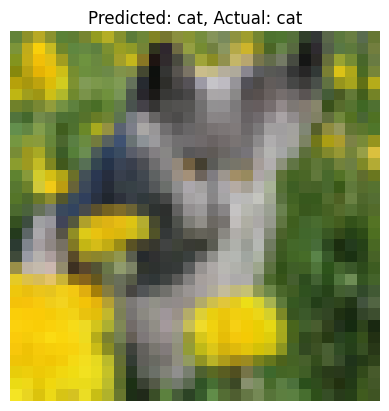

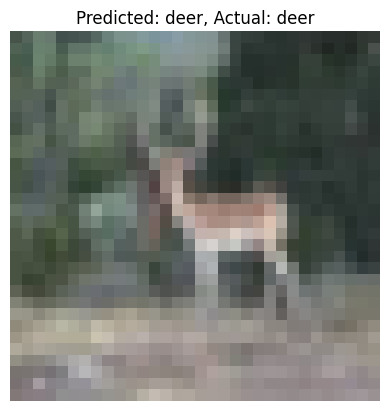

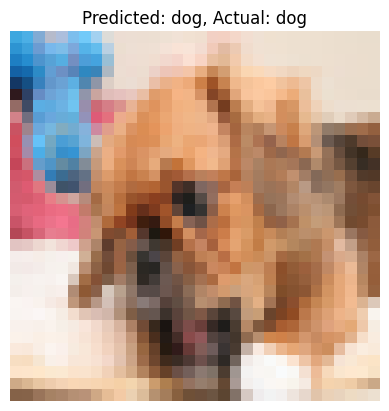

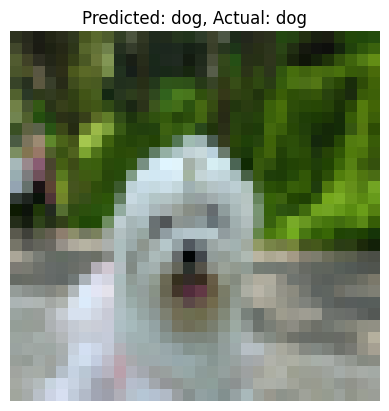

KeyboardInterrupt: 

In [ ]:
# Use the loaded trained HybridModel
model = hybrid_model

# Mean and standard deviation used for normalization (CIFAR-10 dataset)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2434, 0.2616]

# Evaluate the model on random test images and display results
for _ in range(10):

    # Fetch a random test image and its label from the test loader
    data, target = next(iter(testloader))

    # Move the image to the appropriate device (CPU/GPU) before inference
    output = model(data.to(device))  # Forward pass through the model
    _, predicted = torch.max(output, 1)  # Get the class index with highest probability

    # Select the first image from the batch for visualization
    display_img = data[0]

    # Unnormalize the image (convert back to original pixel values)
    unnormalized_image = display_img.clone()  # Create a copy to avoid modifying the original tensor
    for i in range(3):  # Iterate through the 3 channels (RGB)
        unnormalized_image[i] = (unnormalized_image[i] * std[i]) + mean[i]

    # Convert tensor to NumPy format and reshape for visualization
    plt.imshow(np.transpose(unnormalized_image.numpy(), (1, 2, 0)))

    # Display the predicted and actual labels
    plt.title(f'Predicted: {classes[predicted[0]]}, Actual: {classes[target[0]]}')
    plt.axis('off')  # Remove axis labels for a cleaner visualization
    plt.show()  # Display the image


# Model Evaluation

In [ ]:
from torchvision.models import vgg16
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define the file path where the trained VGG16 model is stored
file_path = '/content/drive/MyDrive/IK/CV1/assets/Assignment/vgg16_model.pt'

# Instantiate a new VGG16 model with 10 output classes (e.g., for CIFAR-10)
loaded_vgg_model = VGG16(num_classes=10)

# Load the saved state dictionary (model weights) from the file
saved_state_dict = torch.load(file_path, map_location=torch.device('cpu'))

# Load the saved weights into the newly created model
loaded_vgg_model.load_state_dict(saved_state_dict)

# Set the device: Use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
loaded_vgg_model = loaded_vgg_model.to(device)

# Set the model to evaluation mode (disables dropout, batch norm updates)
loaded_vgg_model.eval()


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [ ]:
from torchvision.models import resnet50
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define the file path where the trained VGG19 model is stored
file_path = '/content/drive/MyDrive/IK/CV1/assets/Assignment/vgg19_model.pt'

# Instantiate a new VGG19 model with 10 output classes (e.g., for CIFAR-10)
loaded_vgg19_model = VGG19(num_classes=10)

# Load the saved state dictionary (model weights) from the file
saved_state_dict = torch.load(file_path, map_location=torch.device('cpu'))

# Load the saved weights into the newly created model
loaded_vgg19_model.load_state_dict(saved_state_dict)

# Set the device: Use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
loaded_vgg19_model = loaded_vgg19_model.to(device)

# Set the model to evaluation mode (disables dropout, batch norm updates)
loaded_vgg19_model.eval()


VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [ ]:
from torchvision.models import resnet50
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Define the file path where the trained ResNet-50 model is stored
file_path = '/content/drive/MyDrive/IK/CV1/assets/Assignment/resnet50_model.pt'

# Load a pre-trained ResNet-50 model (without pre-trained weights)
loaded_resnet_model = resnet50(pretrained=False)

# Modify the classifier (fully connected) layer to match the number of classes
loaded_resnet_model.fc = nn.Linear(in_features=2048, out_features=len(classes))  # Assuming 10 classes

# Load the saved state dictionary (model weights) from the file
saved_state_dict = torch.load(file_path, map_location=torch.device('cpu'))

# Load the saved weights into the newly created model
loaded_resnet_model.load_state_dict(saved_state_dict)

# Set the device: Use GPU if available, otherwise default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
loaded_resnet_model = loaded_resnet_model.to(device)

# Set the model to evaluation mode (disables dropout, batch norm updates)
loaded_resnet_model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(model, data_loader):
    """
    Evaluates the model on a given dataset using accuracy, precision, recall, F1-score, and confusion matrix.

    Args:
    - model (torch.nn.Module): The trained model to be evaluated.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the dataset (e.g., test dataset).

    Returns:
    - accuracy (float): Accuracy score of the model.
    - precision (float): Weighted precision score.
    - recall (float): Weighted recall score.
    - f1 (float): Weighted F1-score.
    - cf_matrix (numpy.ndarray): Confusion matrix.
    """

    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, labels in data_loader:
            images = images.to(device)  # Move images to the appropriate device (CPU/GPU)
            labels = labels.to(device)  # Move labels to the appropriate device

            # Forward pass to get predictions
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)  # Get class with highest probability

            # Store predictions and true labels for evaluation
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true=true_labels, y_pred=predictions)  # Accuracy
    precision = precision_score(y_true=true_labels, y_pred=predictions, average='weighted')  # Precision
    recall = recall_score(y_true=true_labels, y_pred=predictions, average='weighted')  # Recall
    f1 = f1_score(y_true=true_labels, y_pred=predictions, average='weighted')  # F1-score
    cf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)  # Confusion matrix

    return accuracy, precision, recall, f1, cf_matrix


### VGG-16 Model Evaluation

In [ ]:
# Evaluate the loaded VGG16 model on the test dataset
test_accuracy, test_precision, test_recall, test_f1, cf_matrix = evaluate(loaded_vgg_model, testloader)

# Print final test set performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")      # Overall accuracy of the model
print(f"Test Precision: {test_precision:.4f}")    # Precision (weighted average)
print(f"Test Recall: {test_recall:.4f}")          # Recall (weighted average)
print(f"Test F1 Score: {test_f1:.4f}")            # F1-score (weighted average)

# Print the confusion matrix for detailed class-wise performance
print(f"Test Confusion Matrix:")
print(cf_matrix)


KeyboardInterrupt: 

### VGG-19 Model Evaluation

In [ ]:
# Evaluate the loaded VGG19 model on the test dataset
test_accuracy, test_precision, test_recall, test_f1, cf_matrix = evaluate(loaded_vgg19_model, testloader)

# Print final test set performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")      # Overall accuracy of the model
print(f"Test Precision: {test_precision:.4f}")    # Precision (weighted average)
print(f"Test Recall: {test_recall:.4f}")          # Recall (weighted average)
print(f"Test F1 Score: {test_f1:.4f}")            # F1-score (weighted average)

# Print the confusion matrix for detailed class-wise performance
print(f"Test Confusion Matrix:")
print(cf_matrix)


### ResNet-50 Model Evaluation (From the Live Class)

In [ ]:
# Evaluate the loaded ResNet-50 model on the test dataset
test_accuracy, test_precision, test_recall, test_f1, cf_matrix = evaluate(loaded_resnet_model, testloader)

# Print final test set performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")      # Overall accuracy of the model
print(f"Test Precision: {test_precision:.4f}")    # Precision (weighted average)
print(f"Test Recall: {test_recall:.4f}")          # Recall (weighted average)
print(f"Test F1 Score: {test_f1:.4f}")            # F1-score (weighted average)

# Print the confusion matrix for detailed class-wise performance
print(f"Test Confusion Matrix:")
print(cf_matrix)


### Hybrid Model Evaluation (VGG-16, VGG-19, ResNet-18)

In [ ]:
# Evaluate the HybridModel on the test dataset
test_accuracy, test_precision, test_recall, test_f1, cf_matrix = evaluate(hybrid_model, testloader)

# Print final test set performance metrics
print(f"Test Accuracy: {test_accuracy:.4f}")      # Overall accuracy of the model
print(f"Test Precision: {test_precision:.4f}")    # Precision (weighted average)
print(f"Test Recall: {test_recall:.4f}")          # Recall (weighted average)
print(f"Test F1 Score: {test_f1:.4f}")            # F1-score (weighted average)

# Print the confusion matrix for detailed class-wise performance
print(f"Test Confusion Matrix:")
print(cf_matrix)


### Summary
1. **Data Preparation**
- Loaded the CIFAR-10 dataset and applied data augmentation (random cropping, flipping, normalization) for training.
- Created DataLoaders for efficient batch processing.
2. **Model Implementations**
- Implemented VGG16, VGG19, ResNet-50, and a Hybrid Model (VGG16 + VGG19 + ResNet-50).
- Modified the fully connected layers to classify 10 classes.
- Moved models to GPU (if available) for faster computation.
3. **Training and Validation**
- Defined `train_batch()` for forward pass, loss computation, backpropagation, and weight updates.
- Defined `validate_batch()` to evaluate model performance on the test set.
- Applied learning rate scheduling for better training convergence.
4. **Model Saving & Loading**
- Saved trained models as .pt files to avoid retraining.
- Loaded pre-trained models for evaluation.
5. **Evaluation & Performance Metrics**
- Implemented evaluate() to compute accuracy, precision, recall, F1-score, and confusion matrix.
- Evaluated VGG16, VGG19, ResNet-50, and Hybrid Model on the test dataset.
6. **Visualization**
- Displayed model predictions on test images.
- Extracted and visualized feature maps from convolutional layers.